In [1]:
import numpy as np
from matplotlib import pyplot as plt

import os
import pickle
from time import time
from sklearn.decomposition import PCA

import george
from george import kernels
from scipy.optimize import minimize

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

import lhsmdu
import os
import pdspy.modeling as modeling

%matplotlib inline

In [2]:
param_names = ["Tstar","logL_star","logM_disk","logR_disk","h_0","logR_in",\
          "gamma","beta","logM_env","logR_env","f_cav","ksi","loga_max","p","incl"]

bases=[4000.0, 1.0, -5.0, 1.5, 0.255, 0.75, 1.0, 1.25, -5.0, 3.25, 0.5, 1.0, 2.5, 3.5, 45.0]

dictionary=np.load("../grid_metadata/dictionary.npy")

# get all model data
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))[:,100:500]
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))[:,100:500]
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)[100:500]

# fix -infs: powerlaw cutoff
for i in range(len(cube)):
    if -np.inf in cube[i]:
        a = cube[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = cube[i][ind]
        for j in range(ind):
            cube[i][j]=(100*(np.log10(xvals[j]/x1)))+y1
            
# nan cutoff for means            
nancube[nancube<-20]=np.nan

# subtracting from the seds each sample mean
seds_msub = cube - np.nanmean(nancube,axis=1)[:,np.newaxis]

t0 = time()
pca = PCA(n_components=40).fit(seds_msub)
print("done in %0.3fs" % (time() - t0))

eigenseds=np.array(pca.components_)

fitdata=[]

for i in range(len(cube)):
    modeldata=[]
    coeffs=pca.transform(seds_msub[i].reshape(1,-1))
    for k in range(18):
        modeldata.append(coeffs[0][k])
    fitdata.append(modeldata)
    
def load_pcwpar(weight):
    p=[]
    w=[]
    for i in range(len(cube)):
        pars=[]
        for j in range(len(param_names)):
            pars.append(dictionary[i][param_names[j]])
        p.append(pars)
        w.append(fitdata[i][weight])
    
    return p,w

done in 0.096s


In [7]:
X, w0 = load_pcwpar(0)
yerr=[x*0.01 for x in w0]

kernel = np.var(w0) * kernels.ExpSquaredKernel(10000**2,ndim=15,axes=0)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=1)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=2)*\
        kernels.ExpSquaredKernel(0.8**2,ndim=15,axes=3)*\
        kernels.ExpSquaredKernel(0.08**2,ndim=15,axes=4)*\
        kernels.ExpSquaredKernel(0.5**2,ndim=15,axes=5)*\
        kernels.PolynomialKernel(1.7,15,ndim=15,axes=6)*\
        kernels.ExpSquaredKernel(0.2**2,ndim=15,axes=7)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=8)*\
        kernels.ExpSquaredKernel(0.2**2,ndim=15,axes=9)*\
        kernels.ExpSquaredKernel(0.25**2,ndim=15,axes=10)*\
        kernels.ExpSquaredKernel(0.25**2,ndim=15,axes=11)*\
        kernels.ExpSquaredKernel(2**2,ndim=15,axes=12)*\
        kernels.ExpSquaredKernel(3**2,ndim=15,axes=13)*\
        kernels.ExpSquaredKernel(5**2,ndim=15,axes=14) 

#11, ksi - not smooth. may need to change kernel
#6 is gamma - polynomial kernel for tail
# change lengthscale for 7 to ~4 or 5

gp = george.GP(kernel)
gp.compute(X,yerr)

In [8]:
x0pred,x1pred=np.meshgrid(np.linspace(3000, 5000, 100),np.linspace(0, 3, 100))
xpred=[]
for i in range(15):
    xpred.append(bases[i]*np.ones(10000))
xpred[0]=np.ndarray.flatten(x0pred)
xpred[3]=np.ndarray.flatten(x1pred)
x_pred=np.transpose(xpred)

In [9]:
np.set_printoptions(suppress=True)
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(w0)))
print(gp.get_parameter_vector())
print(np.sqrt(np.exp(gp.get_parameter_vector())))

pred, pred_var = gp.predict(w0, x_pred, return_var=True)

Initial ln-likelihood: -75910.46
[ 6.33043192 18.42068074  0.          0.         -0.4462871  -5.05145729
 -1.38629436  1.7        -3.21887582  0.         -3.21887582 -2.77258872
 -2.77258872  1.38629436  2.19722458  3.21887582]
[   23.69386046 10000.             1.             1.
     0.8            0.08           0.5            2.33964685
     0.2            1.             0.2            0.25
     0.25           2.             3.             5.        ]


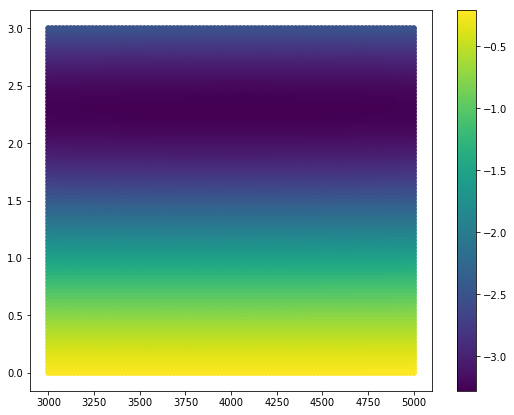

In [10]:
plt.figure(figsize=(9,7))
style = dict(cmap='viridis', vmin=np.min(pred), vmax=np.max(pred))
plt.scatter(np.array(x_pred)[:,0], np.array(x_pred)[:,3], c=pred, s=30, **style)
plt.colorbar()
plt.show()

      fun: 17150.09980463052
 hess_inv: array([[-1.38611193e+09, -1.83523495e+03,  4.66009246e+02,
        -7.19714435e+02,  5.94118052e+02,  3.07536598e+02,
         4.21473489e+02,  9.24027386e+07,  4.66864899e+02,
         3.91506821e+02, -1.51483753e+03,  2.45527855e+02,
         1.05847679e+03, -2.45043296e+03,  4.49619483e+08,
         5.47737495e+02],
       [-1.47825274e+03,  9.25727595e-02,  2.24899289e-04,
        -1.94138088e-04, -4.91469319e-03, -9.20252828e-03,
        -3.04771143e-04,  9.85463985e+01, -4.27719076e-03,
         2.29664445e-03,  4.54134008e-03,  2.32558927e-03,
         5.35753780e-03, -2.22510460e-02,  4.79558402e+02,
        -1.21828936e-02],
       [ 4.79902804e+02,  3.47937166e-04,  5.75897839e-03,
         2.49414369e-04, -3.03190793e-04, -4.55956121e-04,
        -1.53704749e-03, -3.19920109e+01, -7.08741760e-04,
        -3.50265879e-04,  1.48896844e-04,  1.19403297e-03,
        -4.05510809e-04,  2.55304800e-03, -1.55654995e+02,
        -1.45053383e-04

NameError: name 'sample' is not defined

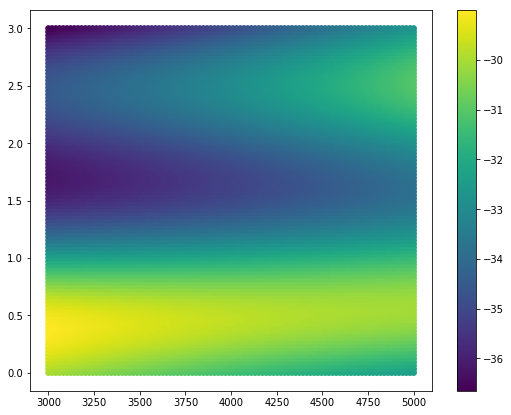

In [11]:
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(w0)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(w0)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(w0)))

print(np.sqrt(np.exp(gp.get_parameter_vector())))

pred, pred_var = gp.predict(w0, x_pred, return_var=True)

plt.figure(figsize=(9,7))
style = dict(cmap='viridis', vmin=np.min(pred), vmax=np.max(pred))
plt.scatter(np.array(x_pred)[:,0], np.array(x_pred)[:,3], c=pred, s=30, **style)
plt.colorbar()

style = dict(cmap='magma', vmin=np.min(pred_var), vmax=np.max(pred_var))
plt.scatter(np.array(x_pred)[sample,0], np.array(x_pred)[sample,1], c=pred_var[sample], s=20, **style)
plt.colorbar()

plt.show()

In [12]:
print(gp.get_parameter_vector())


[-410.64236202   18.43905663    2.41791531    4.32478984    0.28250297
    0.10638909    1.89903252   27.76106203    2.03632082   -0.61001931
   -1.9941214    -1.62429015    0.97362854    5.67730624  147.73658487
    9.81269669]


In [13]:
pred

array([-30.01449243, -30.04391589, -30.07323674, ..., -32.72613193,
       -32.67906894, -32.63188827])

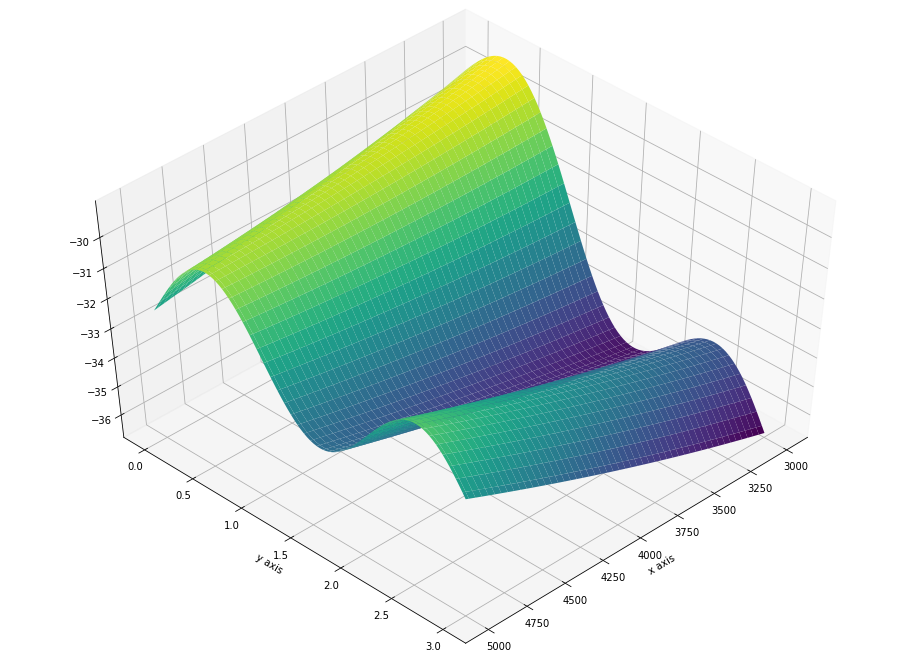

In [14]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111,projection='3d')

# Plot the surface.
surf = ax.plot_surface(x0pred,x1pred,pred.reshape(100,100),cmap=cm.viridis)
ax.set_ylabel("y axis")
ax.set_xlabel("x axis")
ax.view_init(50, 45)
plt.show()
